In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import galsim
import scipy.stats as stats
import seaborn as sns
from importlib import reload
import pandas as pd
%matplotlib inline

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot, generator

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_alpha, denorm, delta_min, norm, load_vae_full
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, plot_rgb, createCircularMask, mean_var, plot_corner_latent, scatter_galaxies
from tools_for_VAE.results_processing import deblender_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Function to import deblender

In [3]:
deblender_lsst,deblender_utils_lsst, encoder_lsst, decoder_lsst, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v6/train_6/',
                                                                                     6, folder = True)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
deblender_lsst_euclid,deblender_utils_lsst_euclid, encoder_lsst_euclid, decoder_lsst_euclid, Dkl = load_vae_full('/sps/lsst/users/barcelin/weights/LSST_EUCLID/deblender/v5/train_7/mse/',
                                                                                            10, folder = True)

# Fix parameters

In [5]:
# Batch size for training
batch_size = 100

# Physical stamp size
phys_stamp_size_euclid = 6.4 # arcsec for VIS Euclid instrument
phys_stamp_size_lsst = 3.2 # arcsec for LSST instrument

# Pixel scales
pixel_scale_euclid_vis = 0.1 # arcsec/pixel
pixel_scale_lsst = 0.2

# Stamp size used
stamp_size = int(phys_stamp_size_euclid/pixel_scale_euclid_vis)

# Load test data

Load shifts and images

In [9]:
data_dir = '/sps/lsst/users/barcelin/data/blended/COSMOS/PSF_lsst_0.65/uni11/test/'
root = 'galaxies_blended_20191004_test'

In [10]:
shifts = np.load(os.path.join(data_dir, root+'_010_shifts.npy'))

In [11]:
images = np.load(data_dir+'galaxies_blended_20191004_test_010_images.npy', mmap_mode = 'c')

Load rest of test data

In [13]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_010_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 21 columns):
nb_blended_gal                10000 non-null int64
SNR                           10000 non-null float64
SNR_peak                      10000 non-null float64
redshift                      10000 non-null float64
moment_sigma                  10000 non-null float64
e1                            10000 non-null float64
e2                            10000 non-null float64
mag                           10000 non-null float64
mag_ir                        10000 non-null float64
closest_x                     10000 non-null float64
closest_y                     10000 non-null float64
closest_redshift              10000 non-null float64
closest_moment_sigma          10000 non-null float64
closest_e1                    10000 non-null float64
closest_e2                    10000 non-null float64
closest_mag                   10000 non-null float64
closest_mag_ir                10000 non-null f

In [15]:
df.head()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_redshift,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
0,2,40.538941,0.056681,0.2264,2.175257,-0.026552,0.049214,26.373794,-0.382880,-0.410607,...,1.4953,1.590679,0.143143,0.221511,29.567116,-2.062741,0.021239,0.159265,0.312474,0.055102
1,1,43.345762,0.074422,0.0219,1.716866,0.052383,-0.153286,26.482803,-0.515679,0.000000,...,0.0219,1.716866,0.052383,-0.153286,26.482803,-0.515679,NaN,NaN,NaN,NaN
2,1,33.746774,0.046207,1.7441,2.249600,-0.136790,-0.382712,26.532654,-1.730437,0.000000,...,1.7441,2.249600,-0.136790,-0.382712,26.532654,-1.730437,NaN,NaN,NaN,NaN
3,4,318.147299,0.300836,0.1662,3.670524,-0.203740,0.175440,23.508441,-3.215953,-0.121300,...,1.1730,2.081314,-0.079631,0.175564,26.699008,-2.977022,0.121712,0.378343,0.732641,0.407208
4,3,85.112223,0.087837,0.7961,3.130349,0.088898,-0.052272,25.171944,-2.594629,0.740828,...,1.3624,1.618648,-0.258741,0.174950,27.748370,-0.520251,0.115619,0.139450,0.481647,0.220966


In [16]:
df.describe()

,nb_blended_gal,SNR,SNR_peak,redshift,moment_sigma,e1,e2,mag,mag_ir,closest_x,...,closest_redshift,closest_moment_sigma,closest_e1,closest_e2,closest_mag,closest_mag_ir,blendedness_total_lsst,blendedness_total_euclid,blendedness_closest_lsst,blendedness_closest_euclid
count,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,7421.000000,7421.000000,7421.000000,7421.000000
mean,2.4842,111.362093,0.171691,0.935891,2.156429,-0.001309,0.000864,26.105825,-1.898260,0.000173,...,1.174166,1.922571,-0.000095,-0.000954,27.292115,-1.203189,0.219586,0.162084,0.545578,0.269076
std,1.1236,230.184429,0.437368,0.723894,0.523718,0.285572,0.282458,1.432332,1.366535,0.409938,...,0.745301,0.351231,0.305348,0.309166,0.978652,1.226625,0.145039,0.167079,0.231570,0.233488
min,1.0000,1.352263,0.001834,0.006500,1.488476,-1.336012,-1.352665,20.037094,-7.306114,-0.999226,...,0.021900,1.488475,-1.832280,-1.574734,20.037094,-7.306114,0.000189,0.000157,0.043904,0.000678
25%,1.0000,23.411316,0.035635,0.418500,1.786459,-0.166515,-0.162834,25.359627,-2.752097,-0.225488,...,0.671900,1.686340,-0.191019,-0.195832,26.880209,-1.910334,0.097044,0.034496,0.353381,0.073001
50%,2.0000,42.474725,0.062798,0.746500,2.027096,0.001238,0.001659,26.379427,-1.752228,0.000000,...,0.990750,1.826825,-0.000237,0.002850,27.443691,-0.990602,0.200227,0.102970,0.544421,0.198105
75%,3.0000,92.411921,0.131158,1.164200,2.358661,0.163062,0.161173,27.108973,-0.918181,0.231861,...,1.487100,2.046902,0.189207,0.192286,27.869905,-0.301550,0.322372,0.237053,0.738272,0.420638
max,4.0000,3050.687094,7.684160,5.197400,5.651824,1.554135,1.914536,29.792827,0.930522,0.999047,...,5.208000,5.546958,1.571674,1.613503,29.792827,0.946252,0.769525,0.919790,0.992873,0.972179


# LSST only

In [176]:
stamp_size_plot = int(stamp_size /2)

In [177]:
N_plot = 9
indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = images[indices]
input_noisy = norm(input_lsst[:,1].transpose([0,2,3,1])[:,:,:,4:], bands_lsst, channel_last = True)
input_noiseless = norm(input_lsst[:,0].transpose([0,2,3,1])[:,:,:,4:], bands_lsst, channel_last = True)

In [178]:
output_deblender_lsst = deblender_lsst.predict(input_noisy, batch_size = 100)

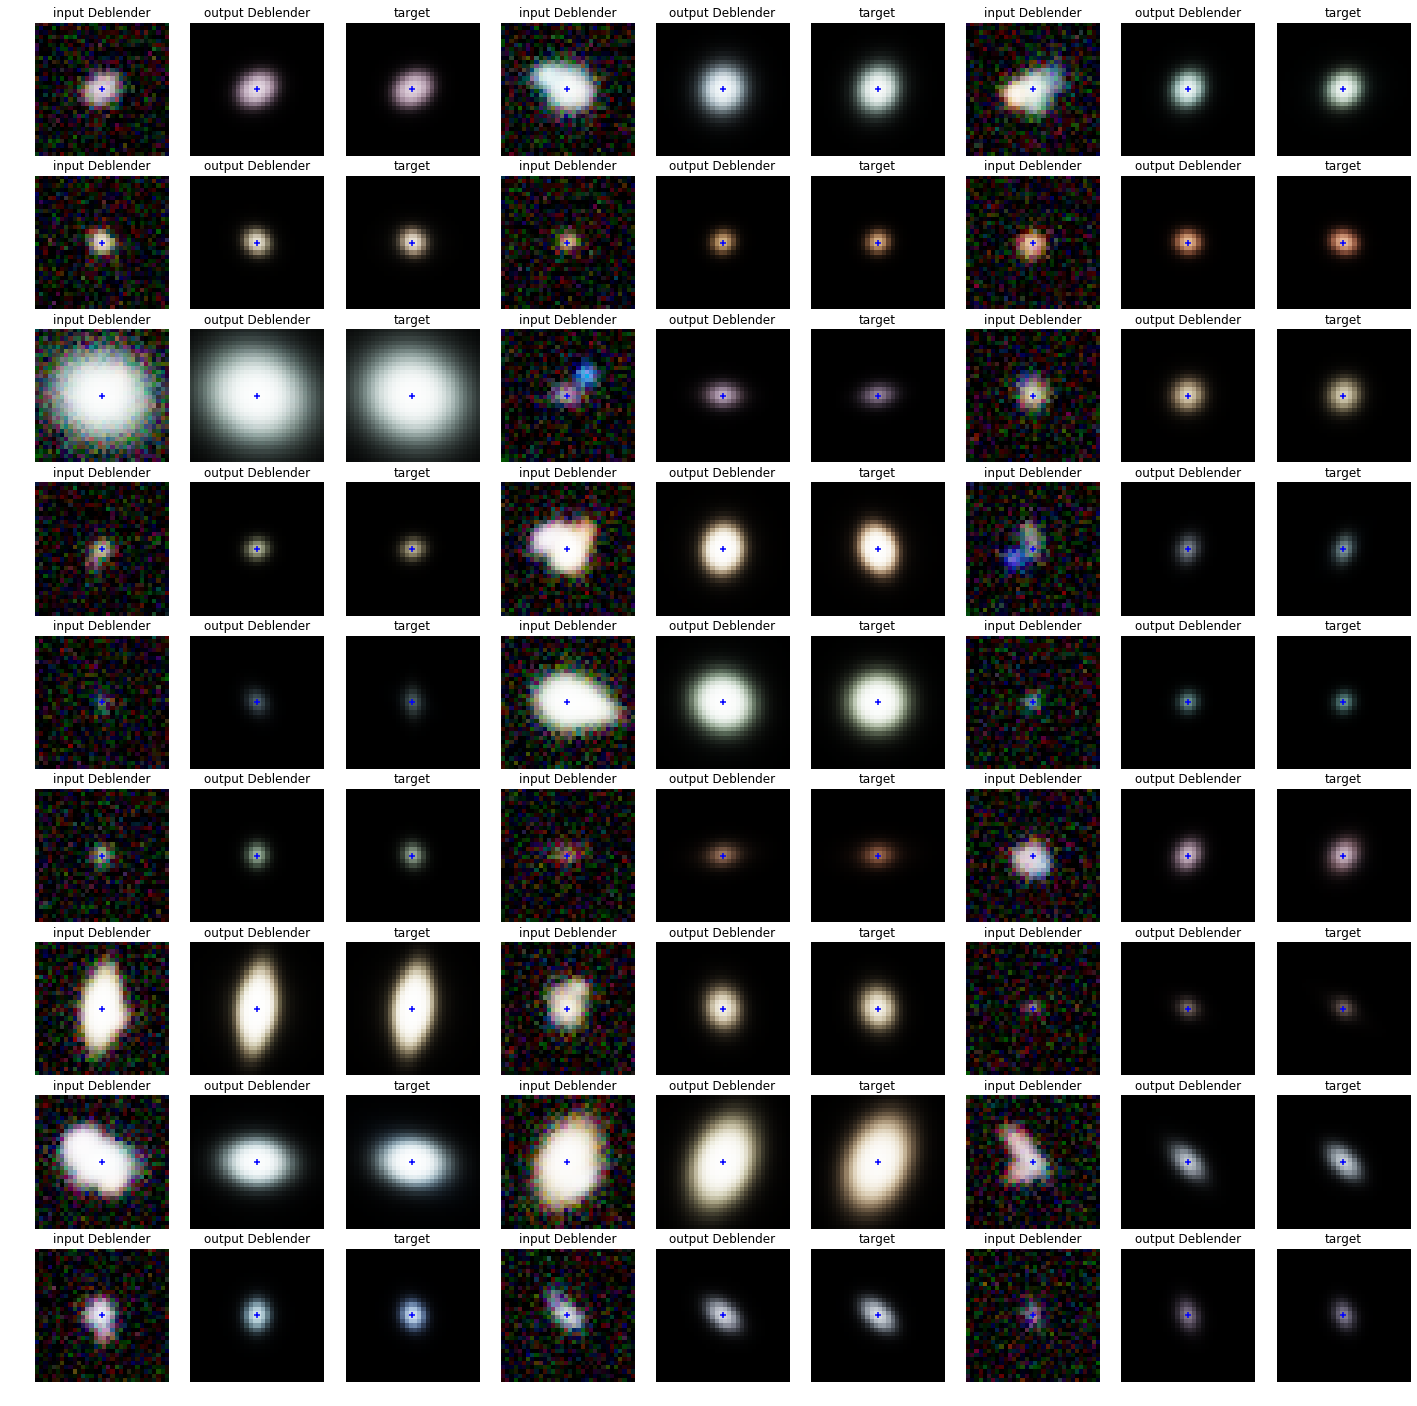

In [179]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

k = 0

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[k], bands = [1,2,3],ax= axes[i,j], band_first= False,zoom = 2)
        plot.plot_rgb(output_deblender_lsst[k], bands = [1,2,3],ax= axes[i,j+1], band_first = False,zoom = 2)
        plot.plot_rgb(input_noiseless[k], bands = [1,2,3],ax= axes[i,j+2], band_first = False,zoom = 2)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        k+=1

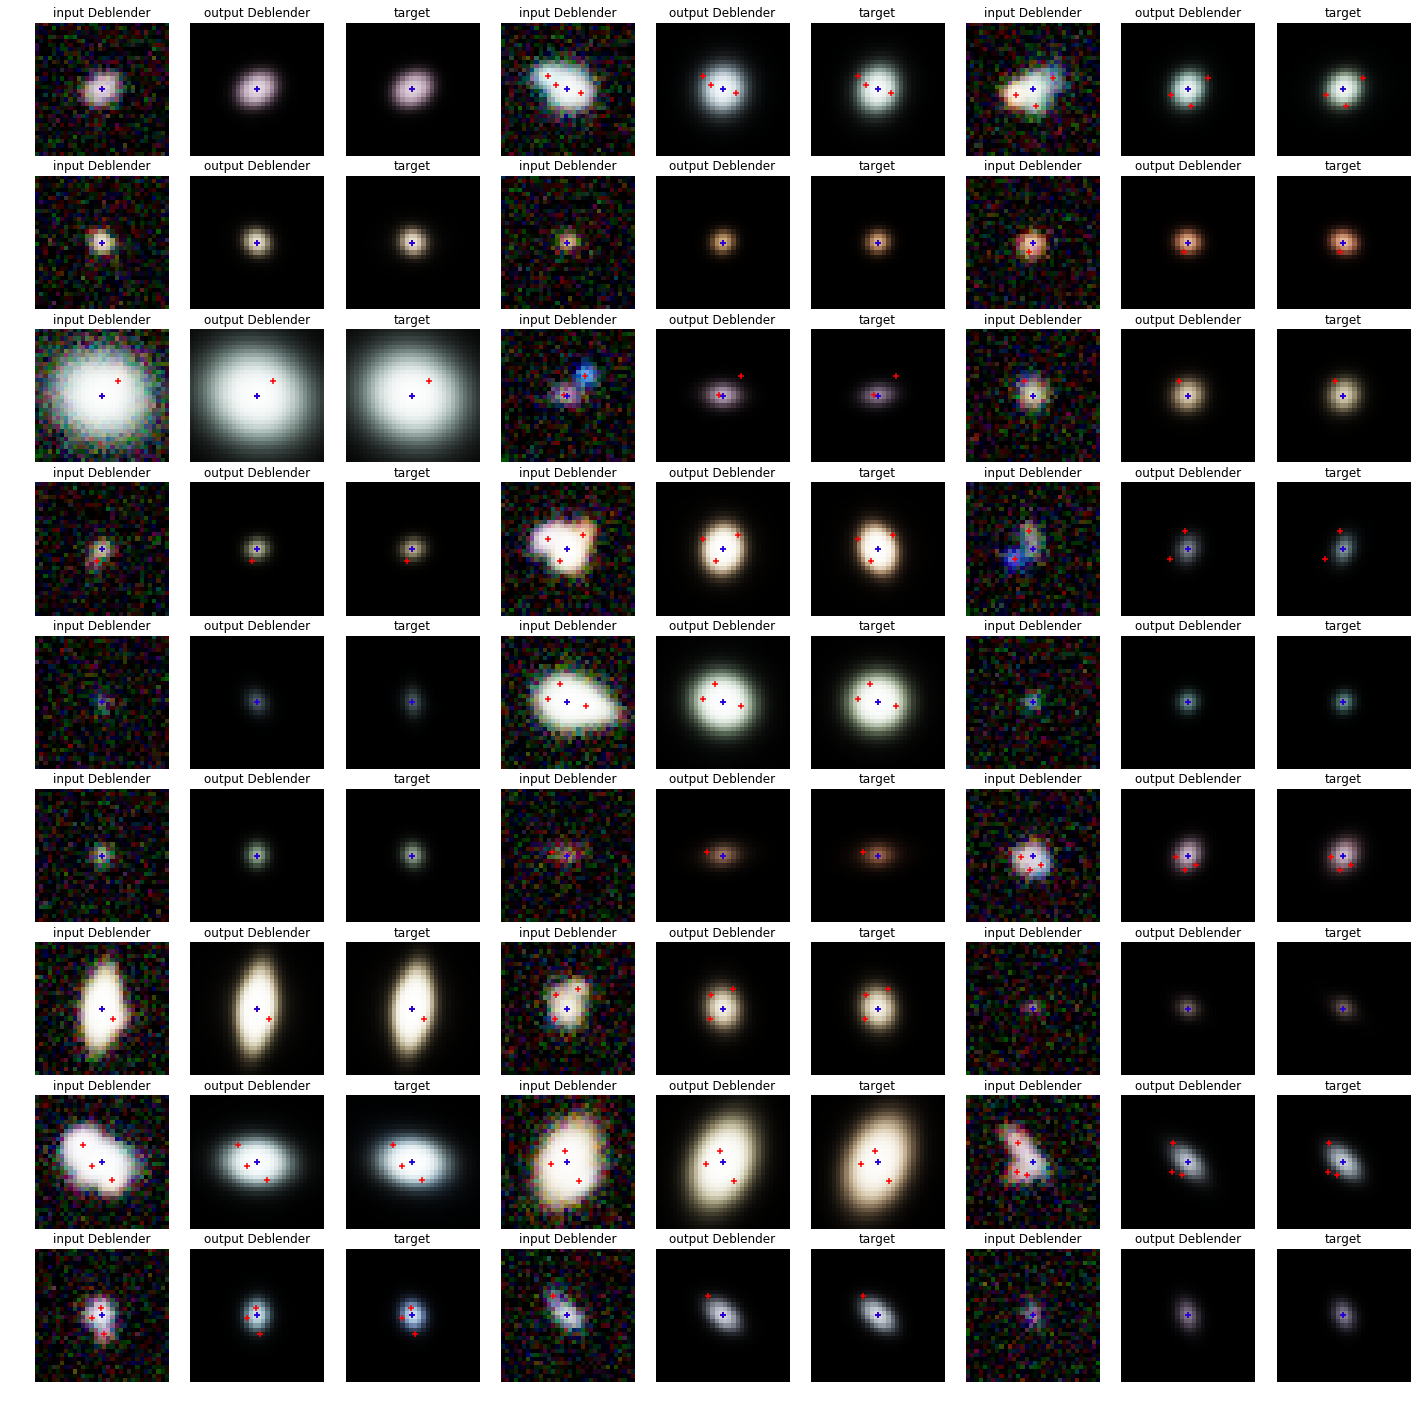

In [180]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

k = 0

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[k], bands = [1,2,3],ax= axes[i,j], band_first= False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)
        plot.plot_rgb(output_deblender_lsst[k], bands = [1,2,3],ax= axes[i,j+1], band_first = False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[k], bands = [1,2,3],ax= axes[i,j+2], band_first = False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        k+=1

# LSST + Euclid

In [168]:
N_plot = 9

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = images[indices]
input_noisy = norm(input_lsst[:,1].transpose([0,2,3,1]), bands_lsst_euclid, channel_last = True)
input_noiseless = norm(input_lsst[:,0].transpose([0,2,3,1]), bands_lsst_euclid, channel_last = True)

In [169]:
output_deblender_lsst_euclid = deblender_lsst_euclid.predict(input_noisy, batch_size = 100)

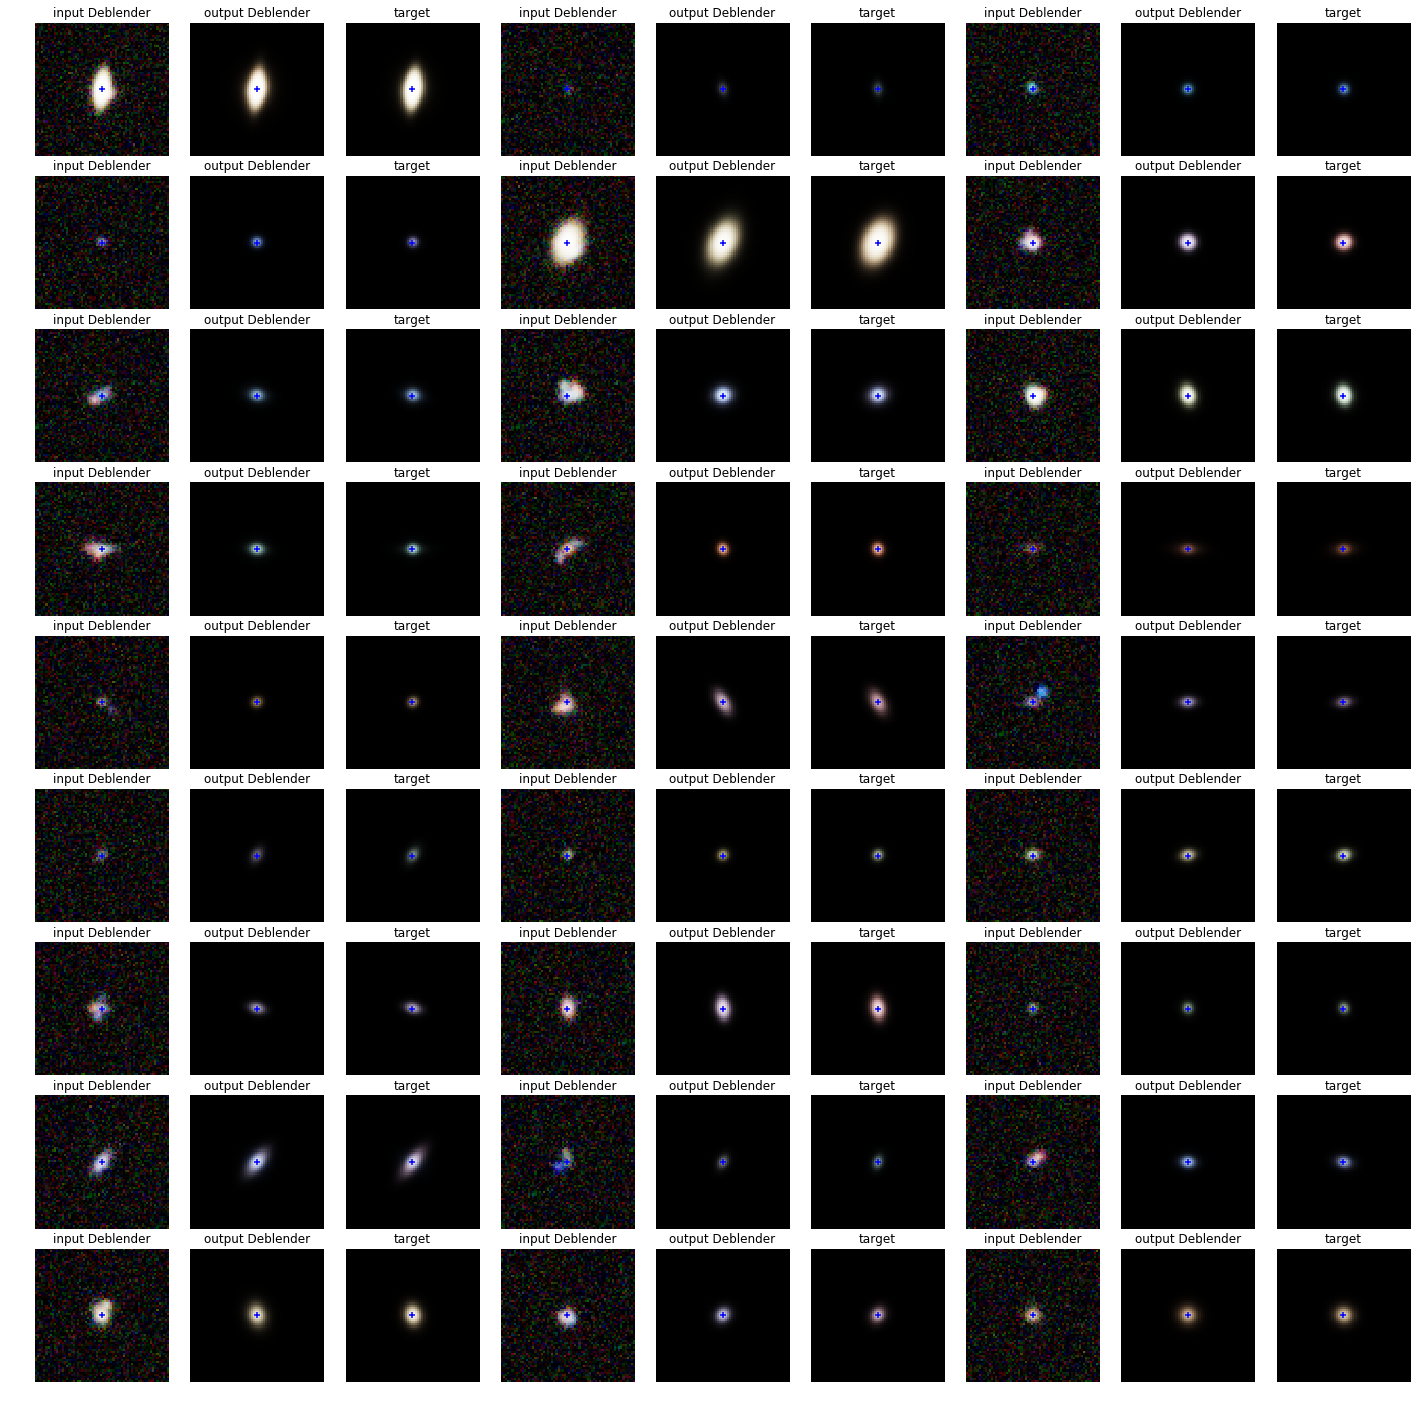

In [174]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

k = 0

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[k], bands = [5,6,7],ax= axes[i,j], band_first= False,zoom = 1)
        plot.plot_rgb(output_deblender_lsst_euclid[k], bands = [5,6,7],ax= axes[i,j+1], band_first = False,zoom = 1)
        plot.plot_rgb(input_noiseless[k], bands = [5,6,7],ax= axes[i,j+2], band_first = False,zoom = 1)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        k+=1

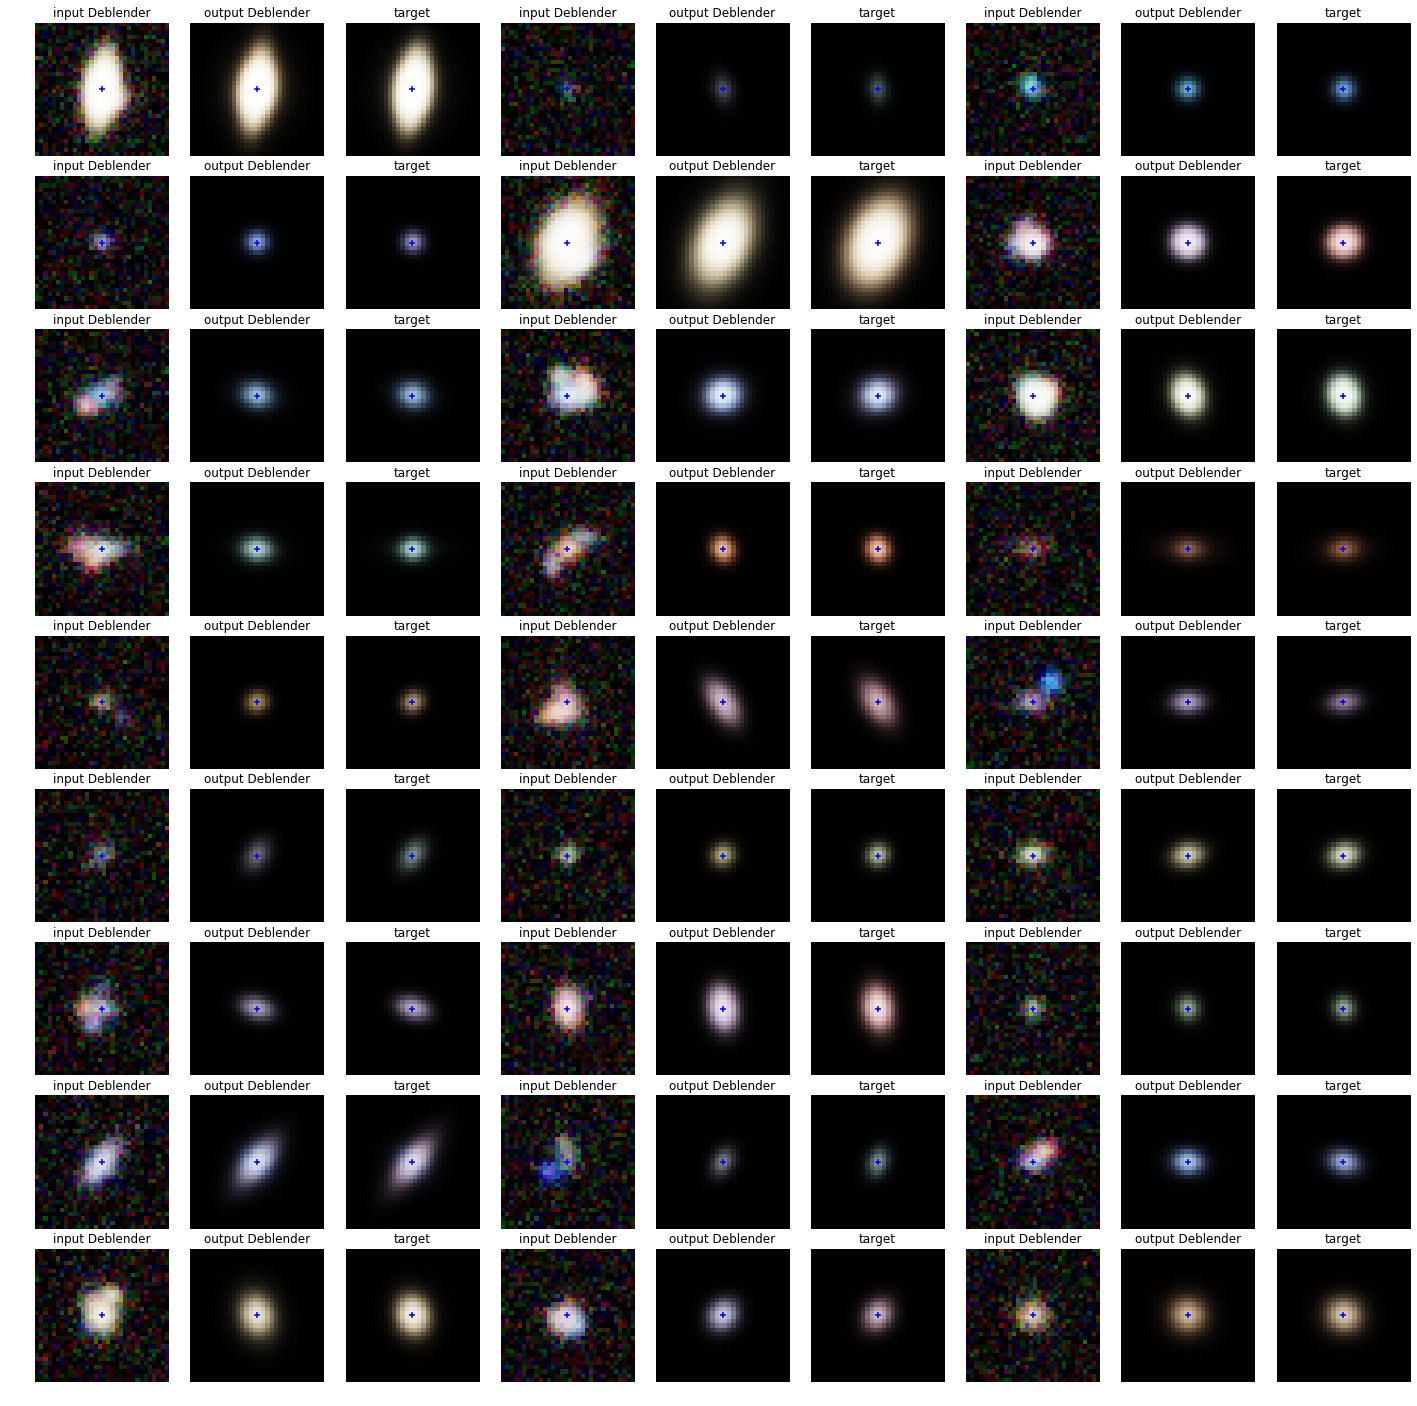

In [173]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

k = 0

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[k], bands = [5,6,7],ax= axes[i,j], band_first= False,zoom = 2)
        plot.plot_rgb(output_deblender_lsst_euclid[k], bands = [5,6,7],ax= axes[i,j+1], band_first = False,zoom = 2)
        plot.plot_rgb(input_noiseless[k], bands = [5,6,7],ax= axes[i,j+2], band_first = False,zoom = 2)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        k+=1

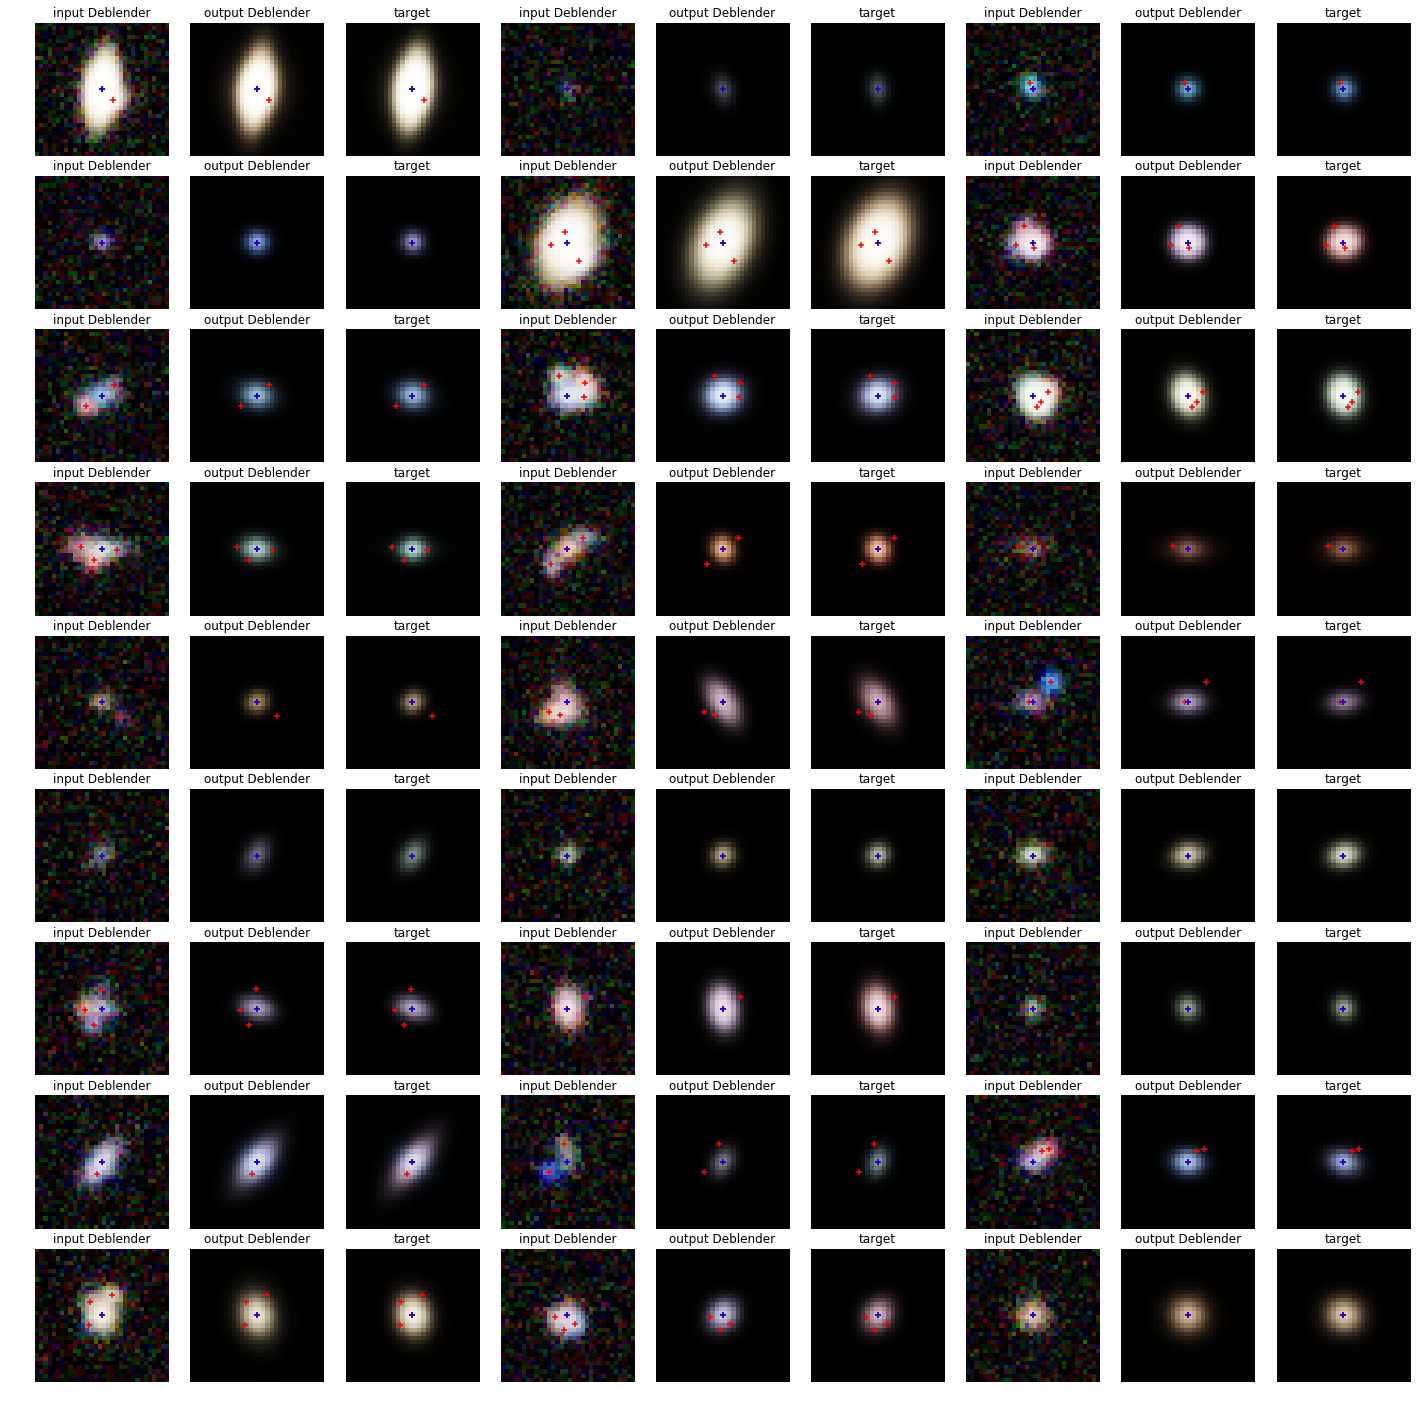

In [172]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

k = 0

for i in range(N_plot):
    for j in range(0,N_plot,3):
        
        plot.plot_rgb(input_noisy[k], bands = [5,6,7],ax= axes[i,j], band_first= False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)
        plot.plot_rgb(output_deblender_lsst_euclid[k], bands = [5,6,7],ax= axes[i,j+1], band_first = False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)
        plot.plot_rgb(input_noiseless[k], bands = [5,6,7],ax= axes[i,j+2], band_first = False,zoom = 2, shifts = shifts[indices[k]]/pixel_scale_lsst)

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        k+=1